# Download Patent DB & Adding Similarity Data

The similarity data on its own provides data on patent doc2vec vectors, and some pre-calculated similarity scores. However, it is much more useful in conjunction with a dataset containing other patent metadata. To achieve this it is useful to download a patent dataset and join it with the similarity data.

There are a number of sources of patent data, if you have a working dataset already it may be easiest to join the similarity data to your own dataset. If however, you do not have a local dataset you can easily download the data from <a href="http://www.patentsview.org/download/">Patentsview</a>

Patentsview offers a lot of data on their bulk download page. For ease of downloading, I have created a Python script that will take care of parsing all those URLs, downloading the CSV files, and reading them into a SQLite database. If you want a local version of the patent data, I recommend you use that script (available <a href = "https://github.com/ryanwhalen/patentsview_data_download">here</a>). Download the 'patentsview_download.py' file to the same folder you have this iPython notebook in and run the code below. Note that downloading may take a significant amount of time. So, run the script using the code below and then go make a cup of coffee. Then go to bed, do whatever you want to do over the course of the next couple of days, and then come back and check up on it.

In [ ]:
%run ./patentsview_download.py

Once you've run the script above, you'll have a local database called 'patent_db.sqlite.' If you want a GUI to check out the contents, I recommend <a href="https://sqlitestudio.pl/">SQLite Studio</a> as a nice open-source option.

The next step is to add the similarity tables to your database. We'll run a separate python script to do so. 

In [ ]:
%run ./write_sim_data_to_db.py

# Initial Similarity Explorations

Everything from here on out assumes that you're using the SQLIte database as constructed above. If you've chosen to marry the similarity data to your own dataset, you'll need to adapt the below as required.

First, let's import a few packages and connect to the DB.

In [4]:
import pandas as pd
import sqlite3
import seaborn as sns
import numpy as np
import random
import gensim
from matplotlib import pyplot as plt
import networkx as nx
import itertools
import os
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
from collections import defaultdict
import json
import csv

db_path ='/mnt/BigDisk1/patent_db_20191231/' #file path to your db file here

conn = sqlite3.connect(db_path+'patent_db.sqlite')
cur = conn.cursor()
cur2 = conn.cursor()

Let's make a pandas dataframe containing the similarity scores between citing/cited patents and the date the citations were made. Note that this may take a few moments, but once the dataframe has loaded working with it should be relatively quick provided your machine has sufficient memory.

In [35]:
df = pd.read_sql_query('''SELECT cite_similarity.similarity,
patent.date FROM cite_similarity 
JOIN patent ON cite_similarity.patent_id = patent.id''', conn)

Let's have a quick look at the dataframe to see what we've loaded

In [3]:
df.head()

,similarity,date
0,0.401575,1994-10-11
1,0.387840,2012-08-21
2,0.305384,2015-12-01
3,0.407260,2008-07-15
4,0.179278,2017-02-21


In [4]:
df.describe()

,similarity
count,7.668256e+07
mean,2.424077e-01
std,1.096889e-01
min,-2.124395e-01
25%,1.692513e-01
50%,2.324749e-01
75%,3.021075e-01
max,9.595724e-01


### Plotting the similarity distribution
Plotting the distribution of similarity scores for all citations shows that most patents tend to cite to other somewhat similar patents, but that there is also substantial variation.

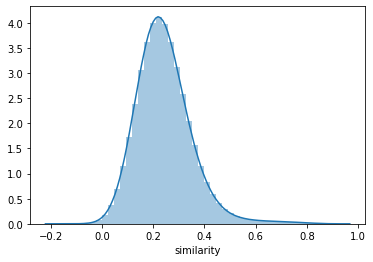

In [5]:
sns.distplot(df['similarity'])

We saw above that citing/cited patents have an average similarity of about 0.26. How do we know how to interpret that number? Well, one way is to compare citing/cited similarity with the similarity scores we would expect to see between random patents. 

The pre-calculated similarity dataset doesn't contain all pairwise similarity scores, so random pairs are unlikely to have a pre-calculated score. We'll need some code that can take two patent numbers, find their vectors and return the similarity score.



In [19]:
def patent_pair_sim(patent1, patent2):
    '''takes 2 patent numbers, finds their doc2vec vectors and returns their cosine similarity'''
    v1 = cur.execute('''SELECT vector FROM doc2vec WHERE patent_id = ?''',[patent1]).fetchone()
    v2 = cur.execute('''SELECT vector FROM doc2vec WHERE patent_id = ?''',[patent2]).fetchone()
    
    if v1 == None or v2 == None: #if either patent has no pre-calculated vector, return None
        return None
    
    v1 = json.loads(v1[0])
    v2 = json.loads(v2[0])

    sim = float(cosine_similarity([v1],[v2])[0])
    return sim

Let's try that similarity calculting function out. Feel free to tweak the below patent numbers if there's a pair you're interested in comparing.

In [4]:
print(patent_pair_sim('9000000','9000001'))

0.1648873633936564


To do some sanity checks, let's compare the similarity of patents randomly paired on various criteria. The CPC codes are a handy place to start. The code below will compare the similarity score distributions for patents which share the same Section (highest level), class (second highest level), or Subclass (third highest level) as their primary categorization. We would expect that patents sharing lower-level CPC classifications will have more in common with one another than those that do not.

In [23]:
def match_on_cpc(patent, level):
    '''takes a patent number and returns a second patent number
    that shares the same cpc group codes'''
    if level == 'subclass':
        group = cur.execute('''SELECT group_id FROM cpc_current WHERE
                        sequence = '0' and patent_id = ?''',[patent]).fetchone()
        if group is None:
            return None
        group = group[0]   
        match = cur.execute('''SELECT patent_id FROM cpc_current WHERE
                          group_id = ? ORDER BY RANDOM() LIMIT 1''',[group]).fetchone()
        match = match[0]
    
    if level == 'section':
        section = cur.execute('''SELECT section_id FROM cpc_current
                              WHERE sequence = '0' and patent_id = ?''',[patent]).fetchone()                          
        if section is None:
            return None
        section = section[0]
        
        match = cur.execute('''SELECT patent_id FROM cpc_current WHERE
                          section_id = ? ORDER BY RANDOM() LIMIT 1''',[section]).fetchone()
        match = match[0]
                          
    if level == 'class':
        class_id = cur.execute('''SELECT subsection_id FROM cpc_current
                              WHERE sequence = '0' and patent_id = ?''',[patent]).fetchone()
        if class_id is None:
            return None
        class_id = class_id[0]                         
        
        match = cur.execute('''SELECT patent_id FROM cpc_current WHERE
                          subsection_id = ? ORDER BY RANDOM() LIMIT 1''',[class_id]).fetchone()
        match = match[0]
    
    return match

def get_cpc_match_sims(n, level):
    '''returns n random pairwise similarities where the pairs
    share the same primary cpc classification at the hierarchical
    level identicated'''
    patents = cur2.execute('''SELECT id FROM patent ORDER BY RANDOM()''')   
    
    sims = []
    
    for p in patents:
        p = p[0]
        if not p.isdigit():
            continue
        match = match_on_cpc(p, level)
        if match == None or match == p:
            continue
        sim = patent_pair_sim(p,match)
        if sim == None:
            continue
        sims.append(sim)
        if len(sims) == n:
            return sims

We can use those functions to get similarity scores for each level of the CPC categorization. This can take some time and requires proper indexing on the DB to work well.

In [27]:
n = 1000

section_match_sims = get_cpc_match_sims(n, level='section')

class_match_sims = get_cpc_match_sims(n, level='class')

subclass_match_sims = get_cpc_match_sims(n, level='subclass')

For good measure, we can also compare with randomly paired patents. We would expect these patents to have the least in common with one another.

In [45]:
def get_random_pairwise_sims(patents, n):
    '''returns the similarities between n randomly paired patents'''
    sims = []
    while len(sims) < n:
        patent1, patent2 = random.sample(patents,2)
        sim = patent_pair_sim(patent1, patent2)
        if sim is None:
            continue
        sims.append(sim)
    return sims

In [ ]:
patents = cur2.execute('''SELECT id FROM patent ORDER BY RANDOM()''').fetchall()
patents = [p[0] for p in patents if p[0].isdigit()]
random_sims = get_random_pairwise_sims(patents, n)

And now, we can compare each of these types of pairs and how similar they are to one another


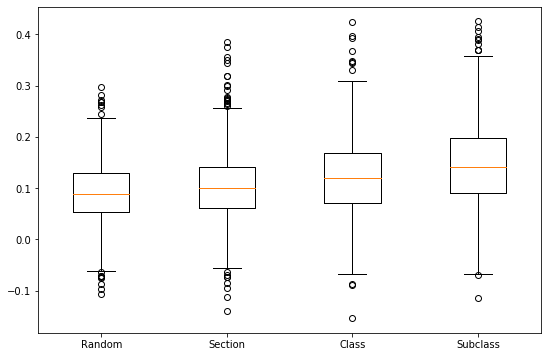

In [44]:
fig = plt.figure(1, figsize=(9, 6))

ax = fig.add_subplot(111)

bp = ax.boxplot([random_sims, section_match_sims, class_match_sims, subclass_match_sims])
ax.set_xticklabels(['Random','Section', 'Class', 'Subclass'])

fig.savefig('cpc_sim_comparisons_bopxplots.png', bbox_inches='tight', dpi=300)

As you can see, the similarity scores track what we would expect to see. So, random patent pairs are least similar, random pairs of patents sharing the same section are somewhat more similar, while those sharing the same class are yet more similar, and those sharing the same subclass are even more similar. As we can see below, all of these differences are statistically significant.

In [31]:
print('Random '+str(np.mean(random_sims)))
print('Section '+str(np.mean(section_match_sims)))
t = stats.ttest_ind(random_sims, section_match_sims)
print(t)
print('Class '+str(np.mean(class_match_sims)))
t = stats.ttest_ind(section_match_sims, class_match_sims)
print(t)
print('Subclass '+str(np.mean(subclass_match_sims)))
t = stats.ttest_ind(class_match_sims, subclass_match_sims)
print(t)

Random 0.09072925841722823
Section 0.10190125584549051
Ttest_indResult(statistic=-3.9236767874298595, pvalue=9.015715315838312e-05)
Class 0.12300700281214517
Ttest_indResult(statistic=-6.649607114439663, pvalue=3.780733420583396e-11)
Subclass 0.14742690323123964
Ttest_indResult(statistic=-7.003324894438409, pvalue=3.401789601717766e-12)


Now, let's get a list of all of the patents, so that we can select some random pairs to compare.

In [6]:
def get_all_patents():
    '''returns a list of all patent numbers in the DB'''
    patents = cur.execute('''SELECT id FROM patent''').fetchall()
    patents = [p[0] for p in patents]
    patents = [p for p in patents if p.isdigit()] #this removes non-numerical patents like design, plant, etc.
    return patents

patents = get_all_patents()

Now let's find the scores for some random pairs and plot that distribution.

In [ ]:
sims = []

for i in range(10000):
    pair = random.choices(patents, k=2)
    sim = patent_pair_sim(pair[0],pair[1])
    if sim is not None:
        sims.append(sim)
        
    
sns.distplot(sims)
print(np.mean(sims))

### Comparing citing/cited similarity to random pairwise similarity
Plotting the two distributions side-by-side shows that - as we would expect - patents that share a citation relationship tend to be more similar than those that do not.

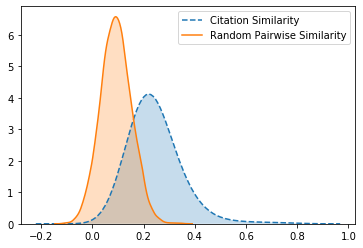

In [38]:
fig, ax = plt.subplots()
sns.kdeplot(df['similarity'], shade=True, ax=ax, label='Citation Similarity', linestyle = '--')
sns.kdeplot(sims, shade=True, ax = ax, label = 'Random Pairwise Similarity')
fig = ax.get_figure()
fig.savefig('cite_vs_random_sim.png', dpi=300)

### Citation similarity over time
Plotting the citation similarity by yearly mean reveals a trend towards decreasing similarity between citing and cited patents.

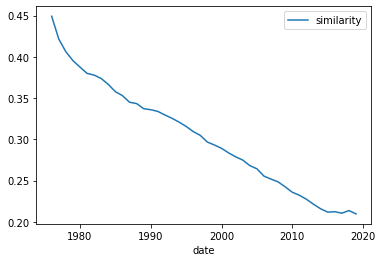

In [39]:
df['date'] = pd.to_datetime(df['date'])
yearly_means = df.groupby(df.date.dt.year).mean()
ax = yearly_means.plot()
fig = ax.get_figure()
fig.savefig('yearly_cite_sim.png', dpi=300)

# Patent-Level Similarity Metrics

As well as identifying global trends, similarity metrics can also provide insight into single inventions. Many patent metrics use citations in combination with metadata such as technical classifications as proxy measures of either knowledge inputs (e.g. Originality) or as a measure of impact (e.g. Generality)(_See_ Trajtenberg, Jaffe and Henderson, 1997). 

The code below can be used to generate a network of forward or backward (e.g. citing or cited) references and their similarity scores. These networks can subsequently be used to define measures of impact or input knowledge diversity. The blue arrows in the diagram below show backwards and forward citation relationships in relation to the focal patent document, while the red arrows represent four different proposed similarity-based citation metrics: (a) knoweldge proximity; (b) knowledge homogeneity; (c) impact proximity; and (d) impact homogeneity.

<img src = "cite_metrics.png">

## Forward and backward distance (knowledge proximity, and impact proximity)

By comparing a patent with its cited or citing prior art, these measures provide insight into the degree to which an invention draws on distant information, or alternately goes on to impact similar or dissimilar inventions. 

Knowledge proximity measures the similarity between the focal patent and its cited backward references.To do so, we calculate the similarities between a patent and its cited prior art, and take the minimum of these similarities as the knowledge proximity score. This provides insight into the degree to which the invention integrates any one piece of particularly distant knowledge. A low knowledge proximity score demonstrates that the invention in question cited to prior art from a very dissimilar field.

Impact proximity is calculated in a simliar manner, but instead measures the similarity between the focal patent and its citing forward references. This provides an impact measure that accounts for the degree to which an invention goes on to influnce technical areas that are similar or dissimilar to its own.


For some of our measures, we'll want to both know a patent's granting year and the years of other related patents. The below function will determine the granting year of any patent. Meanwhile, the yearly_max dictionary stores the highest patent number granted in all the years in the dataset.

In [59]:
def patent_year(patent):
    '''takes a patent number and returns an integer of the year it was granted'''
    date = cur.execute('''SELECT date FROM patent WHERE id = ?''',[patent]).fetchone()
    year = int(date[0].split('-')[0])
    return year

def find_yearly_maxes():
    '''returns a dictionary keyed by year, with values for the highest patent number
    granted in that year'''
    yearly_maxes = {}
    years = range(1976,2020)
    for year in years:
        patents = cur.execute('''SELECT id FROM patent 
                              WHERE strftime('%Y', date) = ?''', [str(year)]).fetchall()
        patents = [p[0] for p in patents]
        patents = [int(p) for p in patents if p.isdigit()]
        yearly_maxes[year] = max(patents)
    return yearly_maxes

yearly_maxes = find_yearly_maxes()

In [56]:
def prior_art_proximity(patent):
    '''takes a patent number, identifies similarity scores for backwards citations and returns 
    the min similarity score - a demonstration of the degree to which the invention draws on distant knowledge'''
    sims = cur.execute('''SELECT similarity FROM cite_similarity WHERE patent_id = ?''',[patent]).fetchall()
    if sims == None:
        return None
    sims = [s[0] for s in sims]
    if len(sims) == 0:
        return None
    return min(sims)

def impact_proximity(patent):
    '''takes a patent number, identifies similarity scores for forward citations and returns 
    the min similarity score - a demonstration of the degree to which the invention has influenced distant areas'''
    year = patent_year(patent)
    
    max_patent = yearly_maxes[year + 10] #the maximum patent number for forward metric comparisons
    
    sims = []
    cites = cur.execute('''SELECT patent_id, similarity FROM cite_similarity WHERE citation_id = ?''',[patent]).fetchall()
    if cites == None:
        return None
    for cite in cites:
        try:
            patent = int(cite[0])
        except:
            continue #skip design, plant and other non numeric patents
        if patent > max_patent: #skip patents granted more than 10-years after focal patent
            continue
        sims.append(cite[1])
    if len(sims) == 0:
        return None
    return min(sims)

We'll want to plot our data by year, which the below function will allow us to do.

In [49]:
def plot_yearly_means(data, label):
    '''takes dictionary with year keys and mean values and plots change over time'''
    xs = sorted(data.keys())
    ys = [data[x] for x in xs]
    plt.plot(xs,ys)
    plt.legend([label])
    plt.tight_layout()
    plt.savefig(label.replace(' ','')+'.png', dpi=300)
    plt.show()

To use the above proximity code and assess potential changes over time, we can use a random smaple of patents. The function below will randomly sample _n_ patents per year and return those patents as a lists in a dictionary keyed by year. To address the truncation in citation data availability, we create two different samples, one to demonstrate the backwards-oriented measures and one to demonstrate the forwards-oriented measures.

In [54]:
def random_yearly_sample(n, years):
    '''takes a vector of years and returns a dict of patents with n randomly sampled per year where year is the key'''
    sample = {}
    for year in years:
        patents = cur.execute('''SELECT id FROM patent WHERE strftime('%Y', date) = ? 
        ORDER BY RANDOM() LIMIT ?''',[str(year), n]).fetchall()
        patents = [p[0] for p in patents]
        sample[year]=patents
    return sample

backward_sample = random_yearly_sample(10000,range(1986,2020)) #sample for backward citation metrics
forward_sample = random_yearly_sample(10000,range(1976,2010)) #sample for forward citation metrics

### Prior Art Proximity

With the sample in hand, we can then calculate the average prior art or impact proximity by year to determine whether there have been changes over time. Note that depending on the size of the sample, this might take some time as it may require many database calls. The cell below will compute the knowledge proximity scores for the random sample we created above to calculate the backwards-focused measures on.

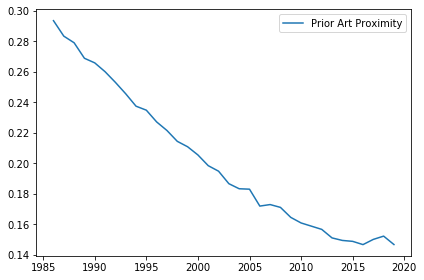

In [57]:
data = {}

for year in backward_sample:
    kp = [prior_art_proximity(i) for i in backward_sample[year]]
    kp = [k for k in kp if k is not None]
    data[year] = np.mean(kp)
    

    
plot_yearly_means(data, 'Prior Art Proximity')

### Impact proximity
Now let's do the same but calculate the forward-oriented impact proximity. 

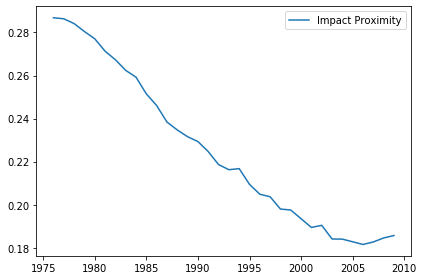

In [60]:
data = {}

for year in forward_sample:
    kp = [impact_proximity(i) for i in forward_sample[year]]
    kp = [k for k in kp if k is not None]
    data[year] = np.mean(kp)
    
   
plot_yearly_means(data, 'Impact Proximity')

### Co-citing and co-cited similarities

Having seen the changes in knowledge and impact proximity over time, let us now look to whether or not knowledge homogeneity or impact homogeneity have changed over time. To do so, we will again use our random sample of yearly patents. This time however, because knowledge homogeneity and impact homogeneity require comparing co-cited or co-citing prior art, we calculate the pairwise similarities between all of the citing or cited prior art for the focal patent. The functions below will perform these calculations and return the minimum similarity between all of the patents cited by the focal patent (knowledge homogeneity) or all of the patents that cite the focal patent (impact homogeneity).

In [61]:
def impact_homogeneity(patent, metric = 'min'):
    '''takes patent number and returns the minimum similarity 
    between co-citing prior art (similar to generality)
    currently implemented to only work for patents we have pre-modeled vectors for
    
    By default returns minium similarity between citing patents, 
    passing metric = mean or median will return those instead '''    

    year = patent_year(patent)
    max_patent = yearly_maxes[year + 10] #the maximum patent number for forward metric comparisons
    
    sims = []
    cites = cur.execute('''SELECT patent_id FROM uspatentcitation WHERE citation_id = ?''',[patent]).fetchall()
    
    if len(cites) < 2: #undefined if fewer than 2 forward cites
        return None
    
    cites = [c[0] for c in cites if c[0].isdigit()] #slice patent numbers out of returned tuples
    cites = [c for c in cites if int(c) < max_patent]
    
    for p1, p2 in itertools.combinations(cites, 2):
        try: #not all patents will have vectors, so use this try loop here
            sim = patent_pair_sim(p1, p2)
            sims.append(sim)
        except:
            continue
    sims = [s for s in sims if s is not None]
    if len(sims) < 1:
        return None
    if metric == 'min':
        return min(sims)
    if metric == 'mean':
        return np.mean(sims)
    if metric == 'median':
        return np.median(sims)
    
def prior_art_homogeneity(patent, metric = 'min'):
    '''takes patent number and returns the minimum similarity 
    between co-cited prior art (similar to originality)
    
    By default returns minium similarity between citing patents, 
    passing metric = mean or median will return those instead '''    

    sims = []
    cites = cur.execute('''SELECT citation_id FROM cite_similarity WHERE patent_id = ?''''',[patent]).fetchall()
    if len(cites) < 2:
        return None
    cites = [c[0] for c in cites]
    for p1, p2 in itertools.combinations(cites, 2):
        sim = patent_pair_sim(p1, p2)
        sims.append(sim)
    sims = [s for s in sims if s is not None]
    if len(sims) < 1:
        return None
    if metric == 'min':
        return min(sims)
    if metric == 'mean':
        return np.mean(sims)
    if metric == 'median':
        return np.median(sims)

### Prior Art Homogeneity

Now let's apply the homogeneity analyses on our backward sample for the knowledge homogeneity score:

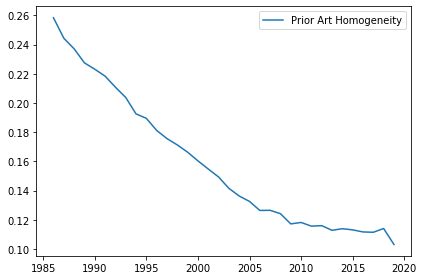

In [62]:
data = {}

for year in backward_sample:
    kp = [prior_art_homogeneity(patent) for patent in backward_sample[year]]
    kp = [k for k in kp if k is not None]
    data[year] = np.mean(kp)

plot_yearly_means(data, 'Prior Art Homogeneity')

### Impact Homogeneity

And on forward samples for the impact homogeneity score:

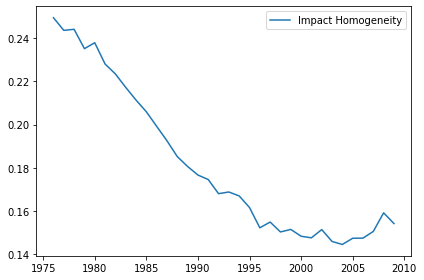

In [64]:
data = {}

for year in forward_sample:
    kp = [impact_homogeneity(patent) for patent in forward_sample[year]]
    kp = [k for k in kp if k is not None]
    data[year] = np.mean(kp)

    
plot_yearly_means(data, 'Impact Homogeneity')  

### Changes in technology space

The above shows both backwards/forward citation similarity and co-cited/co-citing citation similarity have decreased over time. Part of this is likely due to the increasing 'size' of the technological space. As more new inventions are produced, the possible distances between them increases. We can estimate the magnitude of this by randomly sampling patents granted within a given year and plotting their average similarity. If desired, the above raw similarity measures can be adjusted to show their divergence from the similarities we would expect at random. 

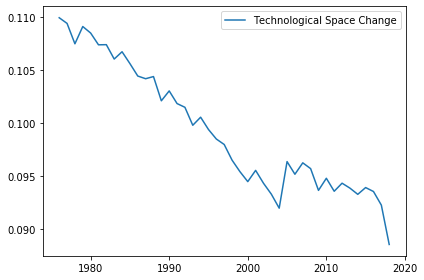

In [65]:
def patents_by_year(year):
    '''returns a set of utility patents granted in the year passed
    as argument'''
    patents = cur.execute('''SELECT id FROM patent 
                          WHERE strftime('%Y', date) = ?''', [str(year)]).fetchall()
    patents = [p[0] for p in patents]
    patents = [int(p) for p in patents if p.isdigit()]
    return patents

data = {}
years = range(1976,2019)
for year in years:
    patents = patents_by_year(year)
    sims = get_random_pairwise_sims(patents, 10000)
    data[year] = np.mean(sims)

plot_yearly_means(data, 'Technological Space Change')

### Similarity by citation type

The above four patent-level citation measures provide insight into the how inventions are related to the prior art that they cite, and those that go on to cite them. However, one might also be interested in citations as traces of the patent application and examination process. Research has suggested that the citations added by patent examiners are qualitatively different from those added by the patent applicants themselves. We can use the patent similarity data to get a sense of the degree to which this is reflected in the semantic similarity of the cited prior art.

The below function will return a vector of simiarity scores for a random sample of citations. It takes as an argument either 'cited by examiner' or 'cited by applicant'.

In [9]:
def get_sims_by_cite_type(n, cite_type):
    '''takes a citation type (cited by applicant, cited by examiner, or cited by other) 
    and returns n random similarity scores between the cited and citing patent'''
    
    cites = cur.execute('''SELECT patent_id, citation_id FROM uspatentcitation 
    WHERE category = ? ORDER BY RANDOM() LIMIT ?''', [cite_type, n]).fetchall()
    sims = []
    for cite in cites:
        try:
            sims.append(patent_pair_sim(cite[0], cite[1]))
        except:
            pass #skip combos not in pre-calculated model
    return sims
            
examiner_sims = get_sims_by_cite_type(50000, 'cited by examiner')
applicant_sims = get_sims_by_cite_type(50000, 'cited by applicant')

Ttest_indResult(statistic=56.87053490351846, pvalue=0.0)


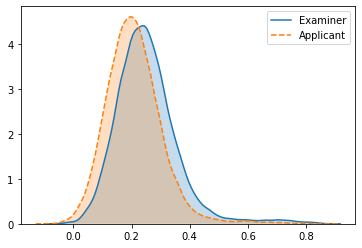

In [10]:
examiner_sims = [s for s in examiner_sims if s is not None]
applicant_sims = [s for s in applicant_sims if s is not None]

fig, ax = plt.subplots()
sns.kdeplot(examiner_sims, shade=True, ax=ax, label='Examiner')
sns.kdeplot(applicant_sims, shade=True, ax = ax, label = 'Applicant', linestyle = '--')
plt.savefig('examiner_applicant_sims'+'.png', dpi=300)

t = stats.ttest_ind(examiner_sims, applicant_sims)
print(t)

## Nearest Neighbors

The patent similarity dataset, also includes data on each patent’s 100 nearest neighbors. These are the 100 patents from the dataset that are closest to the focal patent, and their accompanying similarity scores. These data can be used for a wide variety of analyses, including those that provide perspective on how crowded an invention’s “neighborhood” is. 

As an example, consider the neighborhoods of both litigated and non-litigated patents. To examine whether they differ from one another, we begin with the litigated patent data,  and identify the similarity between each litigated patent and its nearest neighbor. We then compare these similarity scores with the similarity between non-litigated patents and their nearest neighbors. Having a very similar nearest neighbor, suggests that the patent in question is in a ‘crowded’ intellectual property space, with perhaps many other competing, blocking, or related patents, whereas having only more distant neighbors suggests an invention is relatively unique. By comparing the distributions of the nearest neighbor similarities for both litigated and non-litigated patents, we can see that, on average, litigated patents tend to have much more similar nearest neighbors than their non-litigated counterparts, and a wider distribution of these scores.

In [11]:
def make_litigated_patent_set(path):
    '''uses data file from Schwartz et. al litigated patent dataset, returns a set of
    patent numbers involved in infringement litigation'''
    infile = open(path ,encoding = 'utf-8')
    reader = csv.DictReader(infile)
    
    infringement_litigated_patents = set()
    
    count = 0
    for row in reader:
        patent = row['patent']
        doc_type = row['patent_doc_type']
        case_types = [row['case_type_1'], row['case_type_2'],row['case_type_3']]
        if '1' in case_types and doc_type == 'Patent':
            count += 1
            infringement_litigated_patents.add(patent)
    return infringement_litigated_patents
    
def get_nearest_neighbor_sim(patent):
    '''takes a patent number, returns the similarity score for its nearest neighbor
    '''
    sims = cur.execute('''SELECT top_100 FROM most_similar
                       WHERE patent_id = ?''',[patent]).fetchone()
    if sims is None:
        return None
    sims = json.loads(sims[0])
    sims = [s[1] for s in sims]
    return max(sims)

In [14]:
path_to_litigated_dataset = #add path to this dataset file here

litigated_patents = make_litigated_patent_set(path_to_litigated_dataset)

litigated_sims = [get_nearest_neighbor_sim(p) for p in litigated_patents]
litigated_sims = [s for s in litigated_sims if s is not None]

all_patents = get_all_patents()

random_sims = []

while len(random_sims) < len(litigated_sims):
    patent = random.choice(all_patents)
    sim = get_nearest_neighbor_sim(patent)
    if sim is not None:
        random_sims.append(sim)

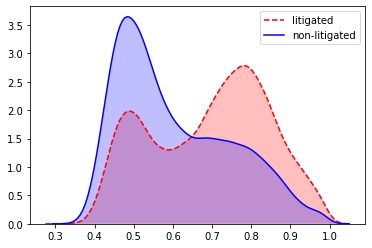

In [15]:
fig, ax = plt.subplots()
sns.kdeplot(litigated_sims, shade = 1, color = 'red', label = 'litigated', linestyle='--')
sns.kdeplot(random_sims, shade = 1, color='blue', label = 'non-litigated')
plt.savefig('litigated_vs_non_litigated.png', dpi=300)

# Inventor-Level Metrics

Patent similarity data can also be used to help understand the career of a given inventor. By locating each of an inventor's inventions within semantic space, one can produce a network of their inventions, measure their average, minimum, and maximum similarity scores, identify clusters, or find their mean invention.

The below code demonstrates how to identify and visualize the invention networks for four well known tech company CEOs.

In [16]:
def make_inventor_net(inventor, save_path = False):
    '''takes inventor ID and returns networkx Graph object containing
    nodes represeting each of his/her inventions with links between them 
    weighted by their doc2vec similarity
    
    if save_path is defined will save a graphml file at the designated path
    '''
    inventions = cur.execute('''SELECT patent_id FROM patent_inventor
    WHERE inventor_id = ?''',[inventor]).fetchall()
    g = nx.Graph()
    if len(inventions) < 2:
        return None
    inventions = [i[0] for i in inventions if i[0].isdigit()]
    for p1, p2 in itertools.combinations(inventions, 2):
        sim = patent_pair_sim(p1, p2)
        if sim is None:
            continue
        g.add_edge(p1, p2, weight = sim)
    if save_path != False:
        nx.write_graphml(g, save_path)
    return g

def make_mst(g):
    '''takes a graph object and returns the minimum spanning tree
    however, defines MST as the maximum sum of edgeweights for a tree
    because the default MST treats weight as distance rather than sim'''
    ng = nx.Graph()
    for edge in g.edges(data=True):
        ng.add_edge(edge[0], edge[1], weight = 1 - edge[2]['weight'])
    ng = nx.minimum_spanning_tree(ng)
    return ng

def net_stats(g):
    '''takes a nx Graph object and returns least similar score (i.e. the similarity 
    between the most dissimilar inventions) and average pairwise similarity'''
    ew = [e[2]['weight'] for e in g.edges(data=True)]
    return round(min(ew),3), round(np.mean(ew), 3)

def draw_inventor_net(g, firstname, lastname):
    d = dict(g.degree(weight='weight'))
    size = [v * 5 for v in d.values()] #rescale  weights for visibility
    least_sim, mean_sim = net_stats(g)
    g = make_mst(g)
    pos = nx.spring_layout(g, iterations = 100)
    fig, ax = plt.subplots()
    nx.draw_networkx_nodes(g, pos, node_size = size,
                            node_color = 'darkslategrey')
    nx.draw_networkx_edges(g, pos)
    plt.xticks([])
    plt.yticks([])
    textstr = '\n'.join((
    r"$\bf{"+firstname+"}$"+" "+r"$\bf{"+lastname+"}$",
        'Minimum sim=%s' % (least_sim,),
        'Mean sim=%s' % (mean_sim,)))
    plt.title(textstr)
    plt.tight_layout()
    plt.savefig(firstname+lastname, dpi=300)
    plt.show()

The first step is to find the inventor IDs of interest. We can do this by looking through the 'inventor' table of the patent_db. Below are the inventor IDs for four well known tech CEOs. We can use these to plot each of their invention networks.

In [17]:
jb_id = '5715399-1'
sj_id = 'D268584-1'
mz_id = '7669123-1'
bg_id = '5552982-2'

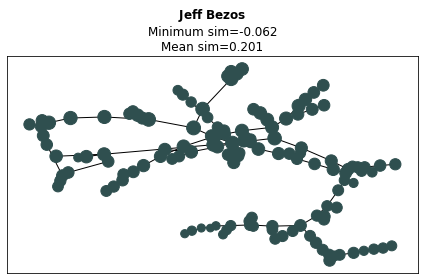

In [20]:
jb = make_inventor_net(jb_id)
draw_inventor_net(jb, 'Jeff', 'Bezos')

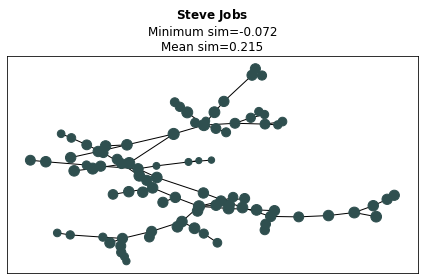

In [21]:
sj = make_inventor_net(sj_id) 
draw_inventor_net(sj, 'Steve', 'Jobs')

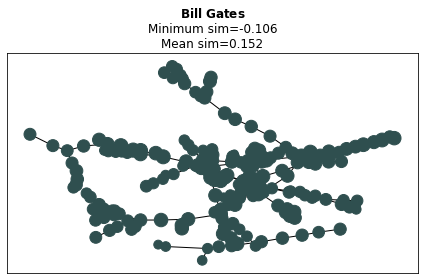

In [23]:
bg = make_inventor_net(bg_id)
draw_inventor_net(bg, 'Bill', 'Gates')

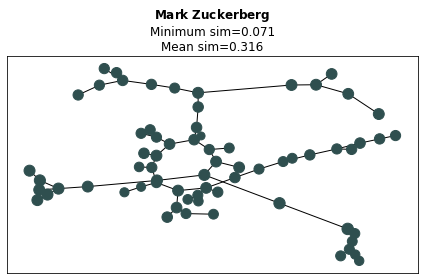

In [24]:
mz = make_inventor_net(mz_id)
draw_inventor_net(mz, 'Mark', 'Zuckerberg')

These visualized networks show the minimum spanning tree of each inventor's patent similarity network, and some basic statistics. Each of these provides insight into the degree to which an inventor has worked within a single technological domain, or has alternately created a wide variety of dissimilar inventions.

### Inter-inventor similarity
Just as we can visualize a given inventor's invention similarity network, we can also compare inventors to one another by identifying their 'mean' invention (i.e. the mean vector of all their invention vectors) and subsequently calcuating the similarity between those.

In [41]:
def find_inventor_mean(inventor):
    '''takes inventor ID, finds their patent vectors and returns mean vector'''
    inventions = cur.execute('''SELECT patent_inventor.patent_id,
    doc2vec.vector FROM patent_inventor
    JOIN doc2vec
    ON patent_inventor.patent_id = doc2vec.patent_id
    WHERE inventor_id = ?''''',[inventor]).fetchall()
    inventions = [i[1][1:-1] for i in inventions if i!= None]
    inventions = [i.split(',') for i in inventions]
    for i in range(len(inventions)):
        inventions[i] = [float(i) for i in inventions[i]]
    if len(inventions) < 1:
        return None
    return np.mean(inventions, axis = 0)

def make_mean_sim_net(means):
    '''takes a list of tuples (node_id, vector) and constructs a network of nodes 
    with edges weighted by the similarity between their vectors'''
    g = nx.Graph()
    for i1, i2 in itertools.combinations(means, 2):
        inv1 = i1[0]
        v1 = i1[1]
        inv2 = i2[0]
        v2 = i2[1]
        sim = float(cosine_similarity(v1.reshape(1,-1), v2.reshape(1,-1))[0])
        g.add_edge(inv1, inv2, weight = sim)
    return g

def plot_inventor_sim_net(g, filename):
    '''takes network of inventors with edges between them weighted by similarity of their mean invention vectors
    plots network'''
    pos = nx.spring_layout(g, iterations = 100)
    nx.draw(g,pos, with_labels = True, node_size = 2000)
    labels = nx.get_edge_attributes(g,'weight')
    nx.draw_networkx_edge_labels(g,pos,edge_labels=labels)
    plt.savefig(filename, dpi=300)
    plt.show()

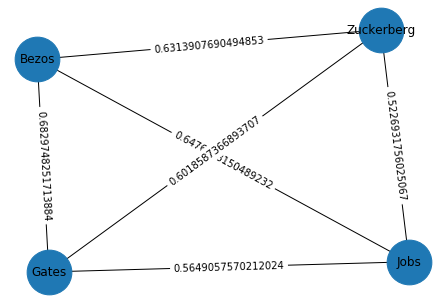

In [43]:
sj = ('Jobs', find_inventor_mean(sj_id))
bg = ('Gates', find_inventor_mean(bg_id))
jb = ('Bezos', find_inventor_mean(jb_id))
mz = ('Zuckerberg', find_inventor_mean(mz_id))

mean_vectors = [sj, bg, jb, mz]

inter_inv_net = make_mean_sim_net(mean_vectors)

plot_inventor_sim_net(inter_inv_net, 'inventor_net.png')

# Team-level metrics

In addition to providing insight into individual patents or inventors, similarity data can be useful at the team-level to characterize different types of collaborative teams. Some teams have are comprised of members largely from the same or similar disciplines, while others feature more expertise diversity in their makeup.

To calculate team-level metrics it is often useful to first typify each individual member's expertise by locating their average semantic location (i.e. the average vector of all of their invention vectors). These mid-points can then be used to typify teams—those with large degrees of similarity between their average vectors are made up of members with similar inventing backgrounds, whereas those with little similarity between them have more knowledge-diverse membership.

In the sample code below, we compare the knowledge diversity of two teams, both inventors on Nest thermostat related patents assigned to Google. The first patent (8,757,507) relates to an easy-to-install thermostat, while the second (9,256,230) relates to scheduling a network-connected thermostat. As we can see from the histogram generated below, the team on the first patent has more concentrated expertise (i.e. generally high similarity scores) whereas the second features more knowledge diversity.

8,757,507 average sim: 0.8481225504029799
9,256,230 average sim: 0.782617227702863


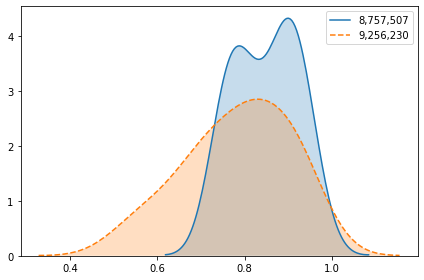

In [49]:
def get_inventors(patent):
    '''takes patent_id returns inventor_ids for listed inventors'''
    inventors = cur.execute('''SELECT inventor_id FROM patent_inventor
        WHERE patent_id = ?''',[patent]).fetchall()
    inventors = [i[0] for i in inventors]
    return inventors

def make_team_network(inventors, save_path =False):
    '''takes a list of inventor IDs, finds mean semantic location for each 
    measures distance between each of their means and returns a network 
    object w/ inventor nodes and weighted edges between them representing
    the similarity of their average inventions'''
    averages = [(i, find_inventor_mean(i)) for i in inventors]
    g = nx.Graph()
    for i1, i2 in itertools.combinations(averages, 2):
        inv1, v1 = i1[0], i1[1]
        inv2, v2 = i2[0], i2[1]
        if v1 is None or v2 is None:
            continue
        sim = float(cosine_similarity(v1.reshape(1,-1), v2.reshape(1,-1))[0])
        g.add_edge(inv1, inv2, weight = sim)
    if save_path != False:
        nx.write_graphml(g, save_path)
    return g


def plot_degree_dists(g1, label1, g2, label2):
    '''takes new network objects (g1 and g2) and accompanying labels
    plots kde of each network degree distribution'''
    ew1 = [e[2]['weight'] for e in g1.edges(data=True)]
    ew2 = [e[2]['weight'] for e in g2.edges(data=True)]
    print(label1 +' average sim: '+str(np.mean(ew1)))
    print(label2 +' average sim: '+str(np.mean(ew2)))
    fig, ax = plt.subplots()
    sns.kdeplot(ew1, shade = True, ax = ax, label = label1)
    sns.kdeplot(ew2, shade = True, ax = ax, label = label2, linestyle = '--')
    plt.tight_layout()
    plt.savefig(label1.replace(',','')+'.png', dpi = 300)
    

team_net_1 = make_team_network(get_inventors('8757507'))
team_net_2 = make_team_network(get_inventors('9256230'))

plot_degree_dists(team_net_1, '8,757,507', team_net_2, '9,256,230')

# Location and firm-level metrics

Because it interfaces easily with other patent data, the patent similarity dataset can also be used to assess innovation at the firm or location level. The code below does a simple comparison of the similarity between inventions made by inventors in California, compared with those located in Louisiana. We see that although the distributions are almost identical, inventions originating in Louisiana are somewhat more likely to be similar to one another than those from California. Similar analyses can be performed to compare firms, or with slight modifications to track changes over time at the firm or location level. 

Ttest_indResult(statistic=14.610251187208295, pvalue=4.27640534194914e-48)


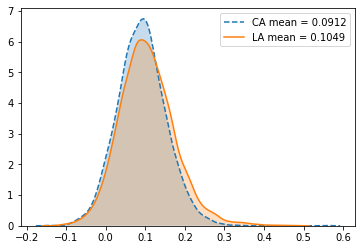

In [31]:
def calc_pairwise_state_sims(state, n):
    '''takes a state abbreviation and returns a 
    returns a list of n random pairwise similarities between patents granted to inventors associated
    with that state in the db'''
    
    patents = cur.execute('''SELECT patent_id FROM patent_inventor WHERE patent_inventor.inventor_id in (
    SELECT inventor_id FROM location_inventor WHERE location_inventor.location_id in 
    (SELECT id FROM location WHERE state = ?)) ORDER BY RANDOM() LIMIT ?''',[state, n]).fetchall()
    patents = [p[0] for p in patents]
    
    sims = []
    while len(sims) < n:
        p1, p2 = random.sample(patents,2)
        sim = patent_pair_sim(p1, p2)
        if sim is not None:
            sims.append(sim)
    return sims


CA_sims = calc_pairwise_state_sims('CA', 10000)
LA_sims = calc_pairwise_state_sims('LA', 10000)

fig, ax = plt.subplots()
sns.kdeplot(CA_sims, shade=True, ax=ax, label='CA mean = %s' % round(np.mean(CA_sims),4), linestyle = '--')
sns.kdeplot(LA_sims, shade=True, ax = ax, label = 'LA mean = %s' % round(np.mean(LA_sims), 4))

t = stats.ttest_ind(LA_sims, CA_sims)
print(t)

fig.savefig('CA_vs_LA_sim.png', bbox_inches='tight', dpi=300)

In [ ]:
conn.close()